In [2]:
import torch
import torch.nn as nn
import hydra
from torch.utils.tensorboard import SummaryWriter
from dust3r.model import AsymmetricCroCo3DStereo, inf  # noqa: F401, needed when loading the model
from dust3r.datasets import get_data_loader  # noqa

from tqdm import tqdm
from sae import SAE, USAE

def set_all_seeds(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def load_dust3r(dust3r_ckpt_path, device):
    return AsymmetricCroCo3DStereo.from_pretrained(dust3r_ckpt_path, device=device)


dataloader = get_data_loader(
    "BlendedMVS(ROOT='data/blendedmvs_processed', resolution=224)",
    batch_size=1,
    num_workers=1
)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dust3r = load_dust3r("checkpoints/DUSt3R_ViTLarge_BaseDecoder_224_linear.pth", device)
dust3r = dust3r.to(device)

hidden_dim = dust3r.enc_norm.normalized_shape[0]

sae = SAE(hidden_dim, int(hidden_dim * 4))

... loading model from checkpoints/DUSt3R_ViTLarge_BaseDecoder_224_linear.pth
instantiating : AsymmetricCroCo3DStereo(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100', img_size=(224, 224), head_type='linear', output_mode='pts3d', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), landscape_only=False)
<All keys matched successfully>


In [4]:
loaded = torch.load("log.pth", map_location=device)
sae.load_state_dict(loaded["model_state_dict"])

<All keys matched successfully>

In [20]:
batch = next(iter(dataloader))
ignore_keys = set(['depthmap', 'dataset', 'label', 'instance', 'idx', 'true_shape', 'rng'])
for view in batch:
    for name in view.keys():  # pseudo_focal
        if name in ignore_keys:
            continue
        view[name] = view[name].to(device, non_blocking=True)
        
    view["img"].requires_grad = True

view1, view2 = batch
(shape1, shape2), (feat1, feat2), (pos1, pos2) = dust3r._encode_symmetrized(view1, view2)

act = torch.concat((feat1, feat2), dim=1)


In [21]:
act_encode, act_recon = sae(act)

In [22]:
energy = (act_encode**2).sum()

In [23]:
energy.backward()

In [94]:
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F

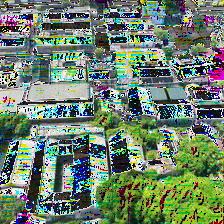

In [108]:
img1_grad = view1["img"].grad
#img1_grad = (img1_grad - img1_grad.mean()) / img1_grad.std()

t = torch.quantile(img1_grad[0], 0.1)
mask = img1_grad[0] > t
coeff = mask.int()
coeff[~mask] = 0.

F.to_pil_image(view1["img"][0] * coeff)

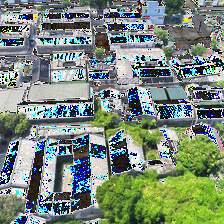

In [109]:
F.to_pil_image(view1["img"][0])

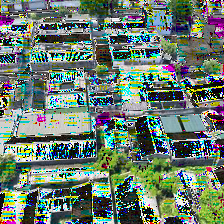

In [110]:
img_grad = view2["img"].grad
#img1_grad = (img1_grad - img1_grad.mean()) / img1_grad.std()

t = torch.quantile(img_grad[0], 0.1)
mask = img_grad[0] > t
coeff = mask.int()
coeff[~mask] = 0.

F.to_pil_image(view2["img"][0] * coeff)

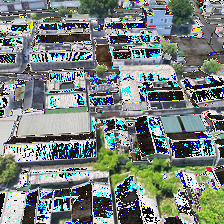

In [105]:
F.to_pil_image(view2["img"][0])